Страница используемого датасета:
https://www.kaggle.com/c/web-traffic-time-series-forecasting/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
%matplotlib inline

In [2]:
!ls

key_1.csv  Palagashvili_BD1.ipynb   sample_submission_2.csv  train_2.csv
key_2.csv  sample_submission_1.csv  train_1.csv


In [3]:
train_2 = pd.read_csv('train_2.csv')
train_2.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [4]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


### Первичный анализ

Данные представляют собой посещаемость страниц википедии.В таблице train_1 охвачен временной промежуток с 2015-07-01 по 2016-12-31.В таблице train_2 охватывается временной промежуток с 2015-07-01 по 2017-09-10.Все переменные имеют тип np.float64, однако,так как количество посещений не может быть дробным и вряд ли будет превышать 2 миллиарда,так что в дальнейшем тип можно будет привести к np.int32.Целью проекта является изучение посещаемости страниц и построение оптимального прогноза посещаемости.Возможно, данное исследование будет полезно при оптимизации нагрузки на серверах. 

### Предобработка + визуализация

В описании соревнования написано,что источник данных не различал нулевую посещаемость и отсутствие данных по страничке, так что, думаю, все пропуски можно смело заполнять нулями.

In [5]:
train_2.fillna(0, inplace=True)

Приведение np.float64 к np.int32

In [6]:
%time
for feat in train_2.columns[1:]:
    train_2[feat] = pd.to_numeric(train_2[feat], downcast='integer')
train_2.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,19,33,33,18,16,27,29,23,54,38
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,...,32,30,11,19,54,25,26,23,13,81
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,...,6,6,7,2,4,7,3,4,7,6
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,...,7,19,19,9,6,16,19,30,38,4
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,16,16,19,9,20,23,28,14,8,7


In [7]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: int32(803), object(1)
memory usage: 445.5+ MB


сэкономили 50% памяти

### Визуальный анализ

In [8]:
train_2.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,19,33,33,18,16,27,29,23,54,38
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,...,32,30,11,19,54,25,26,23,13,81
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,...,6,6,7,2,4,7,3,4,7,6
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,...,7,19,19,9,6,16,19,30,38,4
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,16,16,19,9,20,23,28,14,8,7


Cогласно описанию данных, каждый Page имеет структуру 'name_project_access_agent', причем project содержит 'wikipedia.org'.Проверим,так ли это,и если так, то для каждой записи создадим соответствующие поля

In [9]:
def cont_wiki(page):
    return 'wikipedia.org' in page

In [10]:
train_2[train_2.Page.map(cont_wiki) == False]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
13332,Accueil_commons.wikimedia.org_all-access_spider,55,48,44,35,46,41,32,43,40,...,168,123,58,72,146,3232,5853,46,48,52
13333,Atlas_of_Asia_commons.wikimedia.org_all-access...,5,3,4,6,3,1,5,6,6,...,22,26,28,25,22,20,23,21,23,21
13334,Atlas_of_Europe_commons.wikimedia.org_all-acce...,4,6,9,7,6,4,5,6,13,...,31,30,27,21,33,40,39,21,33,35
13335,Atlas_of_World_War_II_commons.wikimedia.org_al...,5,2,6,6,8,11,5,5,6,...,9,15,9,11,11,7,13,5,9,13
13336,Atlas_of_colonialism_commons.wikimedia.org_all...,8,6,15,5,5,9,10,3,9,...,27,19,29,48,27,23,20,28,27,30
13337,Atlas_of_the_United_Kingdom_commons.wikimedia....,5,7,6,10,7,8,6,3,8,...,9,8,8,15,11,10,15,4,5,8
13338,Atlas_of_the_United_States_commons.wikimedia.o...,10,14,13,20,9,18,10,9,19,...,19,25,17,13,10,18,27,10,14,13
13339,Bikini_commons.wikimedia.org_all-access_spider,4,5,2,2,2,1,5,5,5,...,2,0,4,9,7,9,4,5,3,11
13340,Campaign:OFBA2016_commons.wikimedia.org_all-ac...,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,2,0,0,0,0
13341,Catalogue_of_Wilhelm_von_Gloeden's_pictures_co...,3,4,5,2,3,5,1,1,0,...,6,8,6,8,4,11,8,9,6,14


Видим, что еще остались записи с ресурсами 'mediawiki.org' и 'wikimedia.org'.Улучшим нашу функцию.

In [11]:
def cont_wiki(page):
    return 'wikipedia.org' in page or 'wikimedia.org' in page or 'mediawiki.org' in page 

Победа:

In [12]:
train_2[train_2.Page.map(cont_wiki) == False]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10


Заметим,что перед доменом wikipedia.org также указывается язык страницы.В итоге мы получим 3 новые фичи:
lang, access, agent

In [13]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res[0][0:2]
    return 'na'

train_2['lang'] = train_2.Page.map(get_language)

In [14]:
from collections import Counter

print(Counter(train_2.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [15]:
def get_acc_age(page):
    res = re.search('.org_([^_]+)_([^_]+)$', page)
    if res:
        return res[1], res[2]
    return 'na'

In [16]:
tmp = train_2.Page.map(get_acc_age)

In [17]:
train_2['access'] = tmp.map(lambda x: x[0])
train_2['agent'] = tmp.map(lambda x: x[1])

In [18]:
train_2.loc[:, ['Page', 'agent', 'access', 'lang']]

,Page,agent,access,lang
0,2NE1_zh.wikipedia.org_all-access_spider,spider,all-access,zh
1,2PM_zh.wikipedia.org_all-access_spider,spider,all-access,zh
2,3C_zh.wikipedia.org_all-access_spider,spider,all-access,zh
3,4minute_zh.wikipedia.org_all-access_spider,spider,all-access,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,spider,all-access,zh
5,5566_zh.wikipedia.org_all-access_spider,spider,all-access,zh
6,91Days_zh.wikipedia.org_all-access_spider,spider,all-access,zh
7,A'N'D_zh.wikipedia.org_all-access_spider,spider,all-access,zh
8,AKB48_zh.wikipedia.org_all-access_spider,spider,all-access,zh
9,ASCII_zh.wikipedia.org_all-access_spider,spider,all-access,zh


In [19]:
train_2.loc[:, 'access'].value_counts()

all-access    74315
mobile-web    35939
desktop       34809
Name: access, dtype: int64

In [20]:
train_2.loc[:, 'agent'].value_counts()

all-agents    110150
spider         34913
Name: agent, dtype: int64

Будем строить ряды по каждому признаку.Подготовим данные для визуализации:

In [21]:
lang_sets = {}
lang_sets['en'] = train_2[train_2.lang == 'en'].iloc[:,0:-4]
lang_sets['ja'] = train_2[train_2.lang == 'ja'].iloc[:,0:-4]
lang_sets['de'] = train_2[train_2.lang == 'de'].iloc[:,0:-4]
lang_sets['na'] = train_2[train_2.lang == 'na'].iloc[:,0:-4]
lang_sets['fr'] = train_2[train_2.lang == 'fr'].iloc[:,0:-4]
lang_sets['zh'] = train_2[train_2.lang == 'zh'].iloc[:,0:-4]
lang_sets['ru'] = train_2[train_2.lang == 'ru'].iloc[:,0:-4]
lang_sets['es'] = train_2[train_2.lang == 'es'].iloc[:,0:-4]


lang_sums = {}
for key in lang_sets:
    lang_sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

In [22]:
datetime_indexes = lang_sums['en'].index

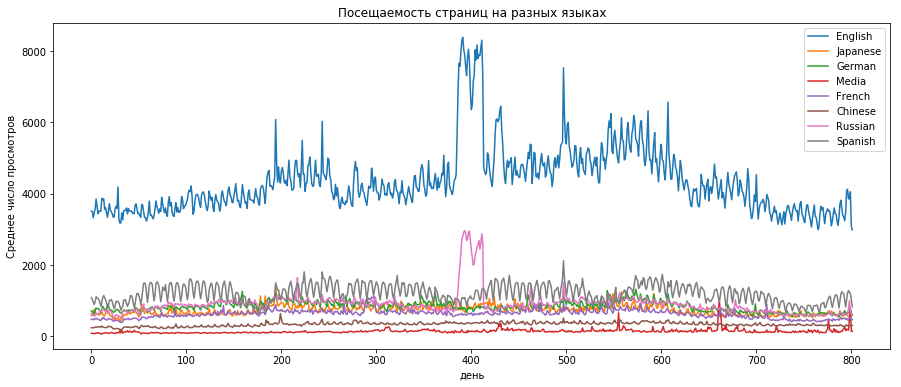

In [23]:
days = [r for r in range(lang_sums['en'].shape[0])]

fig = plt.figure(1,figsize=[15,6])
plt.ylabel('Среднее число просмотров')
plt.xlabel('день')
plt.title('Посещаемость страниц на разных языках')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in lang_sums:
    plt.plot(days, lang_sums[key], label = labels[key] )
    
plt.legend()
plt.show()

In [24]:
print(Counter(train_2.loc[:, 'agent']))

Counter({'all-agents': 110150, 'spider': 34913})


In [25]:
agent_sets = {}
agent_sets['spider'] = train_2[train_2.agent == 'spider'].iloc[:,0:-4]
agent_sets['all-agents'] = train_2[train_2.agent == 'all-agents'].iloc[:,0:-4]

agent_sums = {}
for key in agent_sets:
    agent_sums[key] = agent_sets[key].iloc[:,1:].sum(axis=0) / agent_sets[key].shape[0]

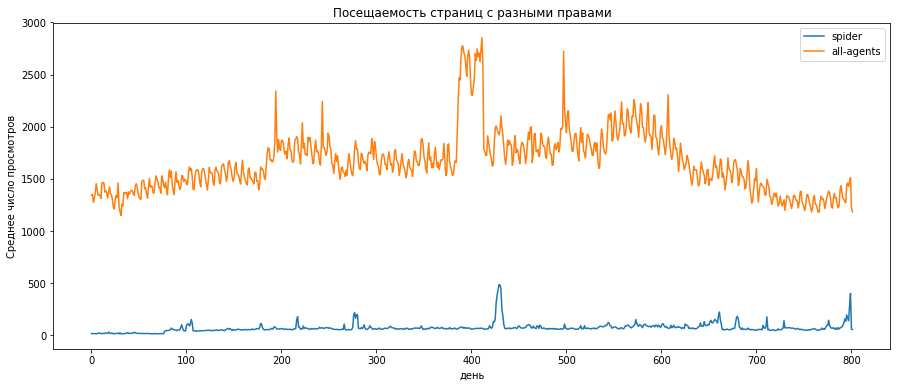

In [26]:
fig = plt.figure(1,figsize=[15,6])
plt.ylabel('Среднее число просмотров')
plt.xlabel('день')
plt.title('Посещаемость страниц c разными правами')

for key in agent_sums:
    plt.plot(days, agent_sums[key], label = key )
    
plt.legend()
plt.show()

In [27]:
print(Counter(train_2.loc[:, 'access']))

Counter({'all-access': 74315, 'mobile-web': 35939, 'desktop': 34809})


In [28]:
access_sets = {}
access_sets['all-access'] = train_2[train_2.access == 'all-access'].iloc[:,0:-4]
access_sets['mobile-web'] = train_2[train_2.access == 'mobile-web'].iloc[:,0:-4]
access_sets['desktop'] = train_2[train_2.access == 'desktop'].iloc[:,0:-4]

access_sums = {}
for key in access_sets:
    access_sums[key] = access_sets[key].iloc[:,1:].sum(axis=0) / access_sets[key].shape[0]

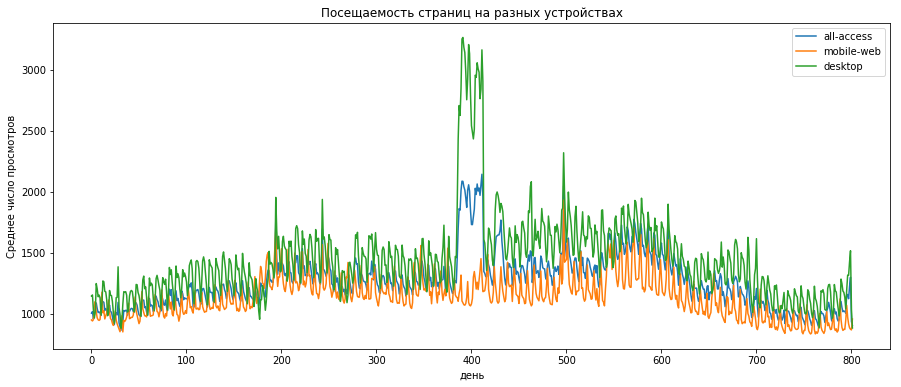

In [29]:
fig = plt.figure(1,figsize=[15, 6])
plt.ylabel('Среднее число просмотров')
plt.xlabel('день')
plt.title('Посещаемость страниц на разных устройствах')

for key in access_sums:
    plt.plot(days, access_sums[key], label = key )
    
plt.legend()
plt.show()

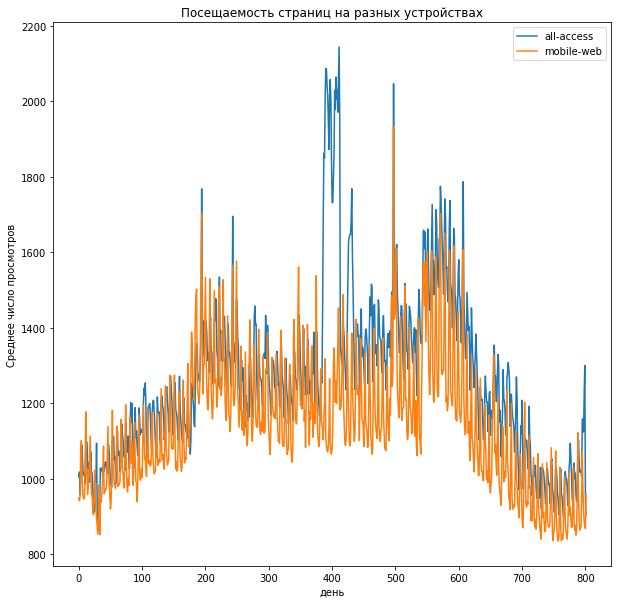

In [30]:
fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Среднее число просмотров')
plt.xlabel('день')
plt.title('Посещаемость страниц на разных устройствах')

for key in access_sums:
    if key != 'desktop':
        plt.plot(days, access_sums[key], label = key )
    
plt.legend()
plt.show()

Видим очень сильный скачок около 500.Посмотрим,что это:

In [31]:
max_feat = np.argmax(access_sums['desktop'][450: 550])

In [32]:
max_feat

'2016-11-09'

In [33]:
max_indexes = train_2.loc[:, [max_feat]].sort_values(by=max_feat, ascending=False)[: 15].index

Взглянем на максимальную посещаемость 2016-11-09 и сравним с посещаемостью этих же страниц в спокойное время:

In [34]:
train_2.loc[max_indexes, ['Page', max_feat, '2016-09-09']]

,Page,2016-11-09,2016-09-09
38573,Main_Page_en.wikipedia.org_all-access_all-agents,25299803,20747572
9774,Main_Page_en.wikipedia.org_desktop_all-agents,19986696,15950112
41072,Donald_Trump_en.wikipedia.org_all-access_all-a...,6137438,87505
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,5236433,4707367
73348,Donald_Trump_en.wikipedia.org_mobile-web_all-a...,3452497,32316
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2900022,2576101
8972,Donald_Trump_en.wikipedia.org_desktop_all-agents,2618353,54481
40841,"United_States_presidential_election,_2016_en.w...",2371810,25182
39180,Special:Search_en.wikipedia.org_all-access_all...,2102357,2064974
39998,Electoral_College_(United_States)_en.wikipedia...,1928256,8717


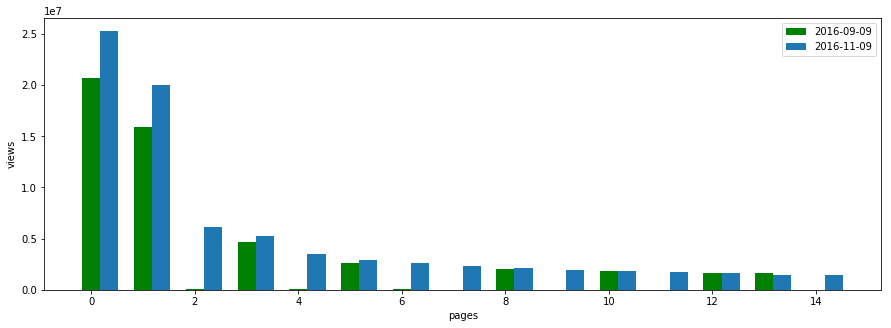

In [35]:
plt.figure(figsize=(15, 5))
bar_width = 0.35
first_date = plt.bar(np.arange(15), 
                     train_2.loc[max_indexes, '2016-09-09'], 
                     bar_width,
                     color='g',
                     label='2016-09-09'
                    )

second_date = plt.bar(np.arange(15) + bar_width, 
                      train_2.loc[max_indexes, max_feat], 
                      bar_width,
                      label=max_feat
                     )

plt.ylabel('views')
plt.xlabel('pages')
plt.legend()

Заметим,кстати, что Main_Page, Hauptseite, Accueil_principal, Portada - аналоги русскоязычной "Заглавной страницы"

Наблюдаем огромный скачок популярности страниц о Дональде Трампе на следующий день после выборов.Видно, кстати, как российские зрители следили за президентской гонкой, скачок пропорционален скачку англоговорящей аудитории
https://tools.wmflabs.org/pageviews/?project=ru.wikipedia.org&platform=all-access&agent=user&start=2016-09-09&end=2016-11-20&pages=%D0%A2%D1%80%D0%B0%D0%BC%D0%BF,_%D0%94%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%B4

Теперь взглянем на скачок посещений страниц на английском в период с 300 по 500 дни.Сразу отметим, что скачок наблюдается и на русскоязычных страницах

In [36]:
max_feat = datetime_indexes[np.argsort(lang_sums['en'])[-1:]][0]

In [37]:
max_feat

'2016-07-26'

In [38]:
max_indexes = train_2.loc[:, [max_feat]].sort_values(by=max_feat, ascending=False)[: 15].index

In [39]:
train_2.loc[max_indexes, ['Page', max_feat, '2016-09-09']]

,Page,2016-07-26,2016-09-09
38573,Main_Page_en.wikipedia.org_all-access_all-agents,67264258,20747572
9774,Main_Page_en.wikipedia.org_desktop_all-agents,62288712,15950112
99322,Заглавная_страница_ru.wikipedia.org_all-access...,16861675,1106801
103123,Заглавная_страница_ru.wikipedia.org_desktop_al...,16349664,595920
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,4792867,4707367
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2720980,2576101
39180,Special:Search_en.wikipedia.org_all-access_all...,2300353,2064974
116196,Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...,1893364,1820546
10403,Special:Search_en.wikipedia.org_desktop_all-ag...,1866130,1633931
27330,Wikipédia:Accueil_principal_fr.wikipedia.org_a...,1600095,1596096


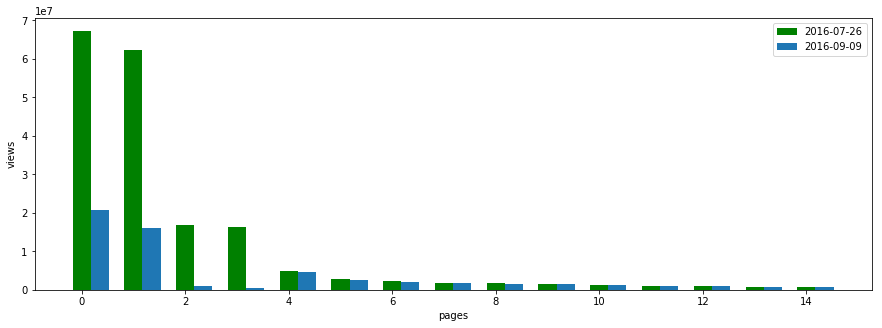

In [40]:
plt.figure(figsize=(15, 5))
bar_width = 0.35
first_date = plt.bar(np.arange(15), 
                     train_2.loc[max_indexes, max_feat], 
                     bar_width,
                     color='g',
                     label=max_feat
                    )

second_date = plt.bar(np.arange(15) + bar_width, 
                      train_2.loc[max_indexes, '2016-09-09'], 
                      bar_width,
                      label='2016-09-09'
                     )

plt.ylabel('views')
plt.xlabel('pages')
plt.legend()

Тут, как и на прошлом графике, мы видим еще один очень большой скачок популярности заглавной страницы википедии(и, как следствие, всего портала).
https://tools.wmflabs.org/pageviews/?project=ru.wikipedia.org&platform=all-access&agent=user&start=2016-06-24&end=2016-12-13&pages=%D0%97%D0%B0%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D0%B0%D1%8F_%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B0

Я уверен, что этот наплыв связан с каким-то громким событием, связанным с вики.Посмотрим еще на два пика, прослеживающихся на промежутке 100-300 на графиках по языкам и по правам

In [41]:
max_feat = np.argmax(access_sums['desktop'][100: 250])

In [42]:
max_feat

'2016-01-11'

In [43]:
max_indexes = train_2.loc[:, [max_feat]].sort_values(by=max_feat, ascending=False)[: 15].index

In [44]:
train_2.loc[max_indexes, ['Page', max_feat, '2016-09-26']]

,Page,2016-01-11,2016-09-26
38573,Main_Page_en.wikipedia.org_all-access_all-agents,19101592,24712373
9774,Main_Page_en.wikipedia.org_desktop_all-agents,12496000,19877904
39945,David_Bowie_en.wikipedia.org_all-access_all-ag...,6977136,11231
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,6344077,4743727
75440,David_Bowie_en.wikipedia.org_mobile-web_all-ag...,3954284,4778
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,3516678,2910349
11187,David_Bowie_en.wikipedia.org_desktop_all-agents,2888263,6282
39180,Special:Search_en.wikipedia.org_all-access_all...,2419293,2262006
116196,Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...,2280602,1838297
10403,Special:Search_en.wikipedia.org_desktop_all-ag...,1959763,1816636


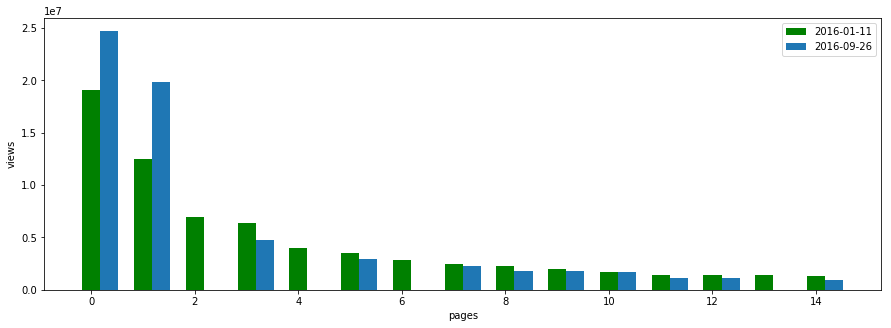

In [45]:
plt.figure(figsize=(15, 5))
bar_width = 0.35
first_date = plt.bar(np.arange(15), 
                     train_2.loc[max_indexes, max_feat], 
                     bar_width,
                     color='g',
                     label=max_feat
                    )

second_date = plt.bar(np.arange(15) + bar_width, 
                      train_2.loc[max_indexes, '2016-09-26'], 
                      bar_width,
                      label='2016-09-26'
                     )

plt.ylabel('views')
plt.xlabel('pages')
plt.legend()

Видим еще один подъем популярности странички:
https://tools.wmflabs.org/pageviews/?project=ru.wikipedia.org&platform=all-access&agent=user&start=2016-01-01&end=2016-09-26&pages=David_Bowie Подъем связан со смертью известного рок-певца.Видно, кстати, что его основная аудитория англоговорящей

Рассмотрим еще один пик с 230 по 300

In [46]:
max_feat = np.argmax(access_sums['desktop'][230: 300])

In [47]:
max_feat

'2016-02-29'

In [48]:
max_indexes = train_2.loc[:, [max_feat]].sort_values(by=max_feat, ascending=False)[: 15].index

In [49]:
train_2.loc[max_indexes, ['Page', max_feat, '2016-09-26']]

,Page,2016-02-29,2016-09-26
38573,Main_Page_en.wikipedia.org_all-access_all-agents,21580285,24712373
9774,Main_Page_en.wikipedia.org_desktop_all-agents,15512692,19877904
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,5833657,4743727
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,3247078,2910349
39180,Special:Search_en.wikipedia.org_all-access_all...,2315267,2262006
116196,Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...,2257399,1838297
39217,Steve_Blake_en.wikipedia.org_all-access_all-ag...,2084443,204
10438,Steve_Blake_en.wikipedia.org_desktop_all-agents,2083355,108
10403,Special:Search_en.wikipedia.org_desktop_all-ag...,1930845,1816636
40307,Leonardo_DiCaprio_en.wikipedia.org_all-access_...,1752276,20449


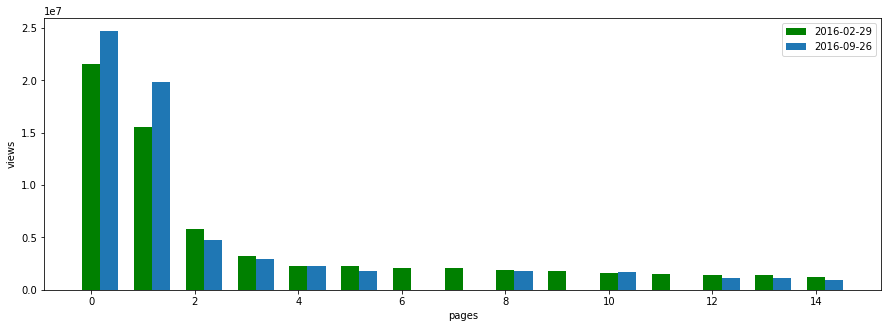

In [50]:
plt.figure(figsize=(15, 5))
bar_width = 0.35
first_date = plt.bar(np.arange(15), 
                     train_2.loc[max_indexes, max_feat], 
                     bar_width,
                     color='g',
                     label=max_feat
                    )

second_date = plt.bar(np.arange(15) + bar_width, 
                      train_2.loc[max_indexes, '2016-09-26'], 
                      bar_width,
                      label='2016-09-26'
                     )

plt.ylabel('views')
plt.xlabel('pages')
plt.legend()

Ну тут понятно:первое-получение долгожданного оскара Дикаприо
https://tools.wmflabs.org/pageviews/?project=ru.wikipedia.org&platform=all-access&agent=user&start=2016-01-01&end=2016-09-26&pages=Leonardo_DiCaprio
https://tools.wmflabs.org/pageviews/?project=en.wikipedia.org&platform=all-access&agent=user&start=2016-02-26&end=2016-09-26&pages=88th_Academy_Awards
Не знаю, что стало триггером для страницы о Стиве Блейке, но скачок крутой:
https://tools.wmflabs.org/pageviews/?project=en.wikipedia.org&platform=all-access&agent=user&start=2016-02-26&end=2016-09-26&pages=Steve_Blake

### Проверка гипотез

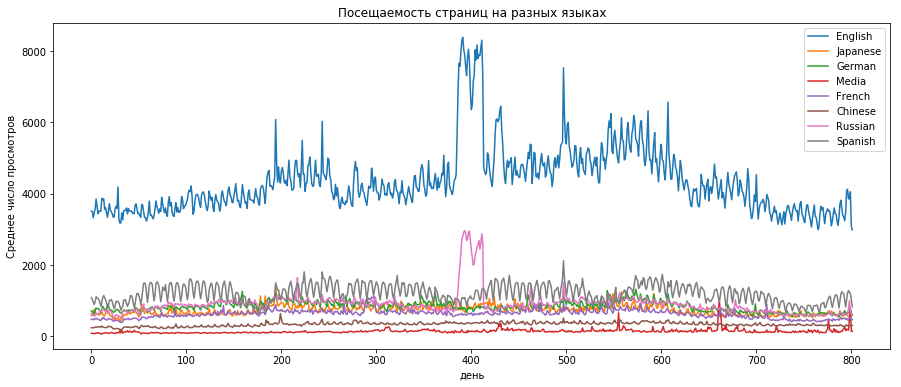

In [51]:
days = [r for r in range(lang_sums['en'].shape[0])]

fig = plt.figure(1,figsize=[15,6])
plt.ylabel('Среднее число просмотров')
plt.xlabel('день')
plt.title('Посещаемость страниц на разных языках')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in lang_sums:
    plt.plot(days, lang_sums[key], label = labels[key] )
    
plt.legend()
plt.show()

Для всех гипотез заранее установим уровень значимости 5%

Первой из гипотез предлагаю рассмотреть следующую:

H0:среднее число просмотров страниц на испанском до 400-го дня и после 400-го дня не изменилось

H1:среднее число просмотров изменилось

Взглянем на распределение:

In [52]:
before = lang_sums['es'][: 400][: 400]
after = lang_sums['es'][400: ][: 400]

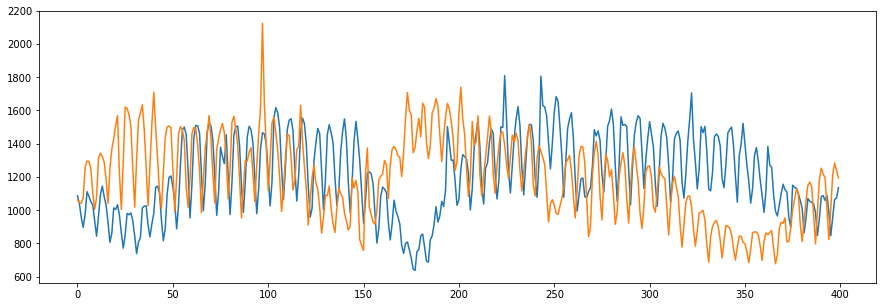

In [53]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(400), before)
plt.plot(np.arange(400), after)

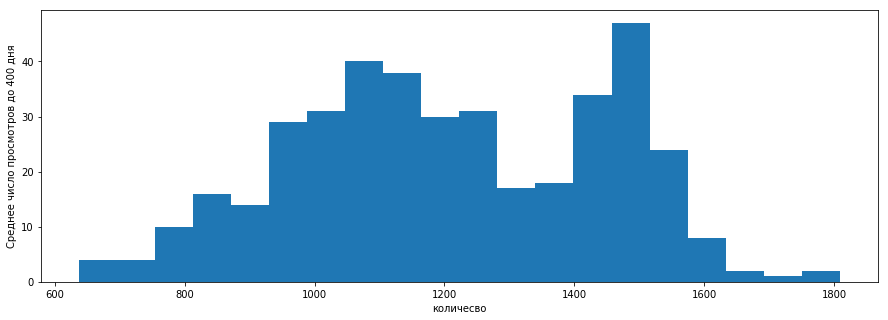

In [54]:
plt.figure(figsize=(15, 5))
plt.ylabel('Среднее число просмотров до 400 дня')
plt.xlabel('количесво')
plt.hist(before, bins=20)
plt.show()

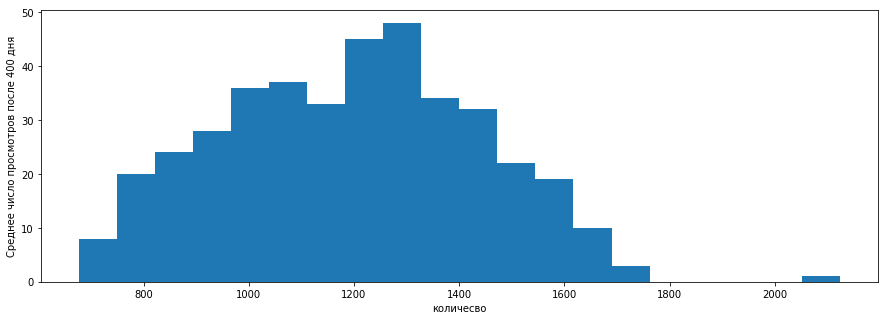

In [55]:
plt.figure(figsize=(15, 5))
plt.ylabel('Среднее число просмотров после 400 дня')
plt.xlabel('количесво')
plt.hist(after, bins=20)
plt.show()

In [56]:
before.mean()

1210.4848626412686

In [57]:
after.mean()

1194.5241152533933

Давайте попробуем применить критерий Шапиро-Уилка на нормальность:

In [58]:
from scipy import stats

In [59]:
stats.shapiro(before)

(0.9765853881835938, 4.62469324702397e-06)

In [60]:
stats.shapiro(after)

(0.9866094589233398, 0.0009535145945847034)

О нормальности говорить не приходится.Придется использовать непараметрический критерий.Воспользуемся двувыборочным критерием Колмогорова-Смирнова:

In [61]:
stats.anderson_ksamp((before, after))

Anderson_ksampResult(statistic=0.8715272088728665, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=0.14333578518137316)

Значение статистики меньше, чем 5-процентное критическое значение(1.961).
Значит, гипотеза H0 не может быть отвергнута.Воспользуемся тестом Колмогорова-Смирнова:

In [62]:
stats.ks_2samp(before, after)

Ks_2sampResult(statistic=0.087500000000000022, pvalue=0.088475418079021526)

p-value > 5%, гипотеза не отвергается.Принимаем гипотезу о том,что среднее количество просмотров страниц на испанском не изменилось.

Теперь же давайте рассмотрим страницы на английском и возьмем данные за первые 350 и последние 350 дней

In [63]:
before_en = lang_sums['en'][: 350]
after_en = lang_sums['en'][-350: ]

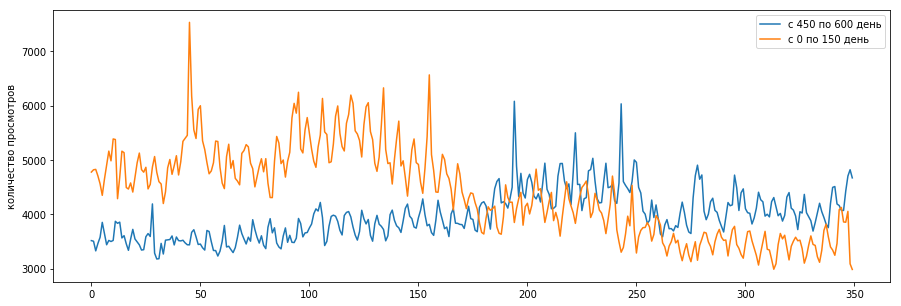

In [64]:
plt.figure(figsize=(15, 5))
plt.ylabel('количество просмотров')
plt.plot(np.arange(350), before_en, label='с 450 по 600 день')
plt.plot(np.arange(350), after_en, label='с 0 по 150 день')
plt.legend()

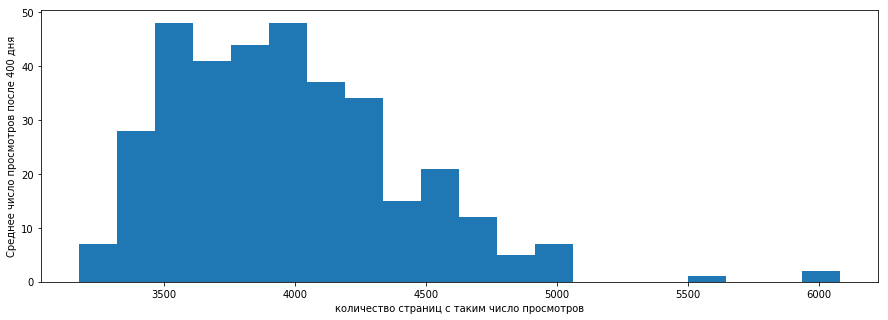

In [65]:
plt.figure(figsize=(15, 5))
plt.ylabel('Среднее число просмотров после 400 дня')
plt.xlabel('количество страниц с таким число просмотров')
plt.hist(before_en, bins=20)
plt.show()

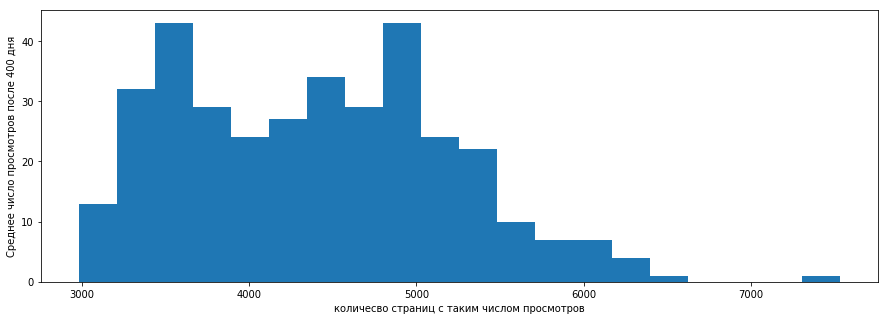

In [66]:
plt.figure(figsize=(15, 5))
plt.ylabel('Среднее число просмотров после 400 дня')
plt.xlabel('количесво страниц с таким числом просмотров')
plt.hist(after_en, bins=20)
plt.show()

In [67]:
stats.anderson_ksamp((before_en, after_en))

/home/abi/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


Anderson_ksampResult(statistic=52.300405624052537, critical_values=array([ 0.325,  1.226,  1.961,  2.718,  3.752]), significance_level=919027.8878937617)

In [68]:
stats.ks_2samp(before_en, after_en)

Ks_2sampResult(statistic=0.34571428571428575, pvalue=6.0218438417818573e-19)

Гипотеза о том, что число просмотров не изменилось отвергается.
Теперь попробуем рассмотреть что-нибудь для параметрического критерия.

In [29]:
from scipy.stats import kstest

In [24]:
data = train_2.iloc[1:, 1]

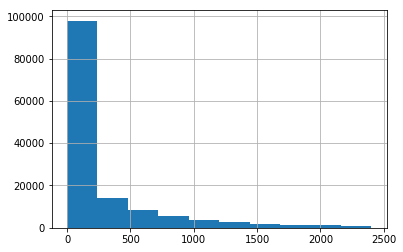

In [40]:
data[data < data.quantile(0.95)].hist()

In [31]:
kstest(data, 'expon')

KstestResult(statistic=0.7324323171576459, pvalue=0.0)

### Построение прогноза

Я буду строить лишь прогноз для главной страницы,а не для каждой позиции в ряду,как это требуется в конкурсе.(компьютер маломощный)

In [43]:
main = train_2[train_2.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']

In [44]:
main.iloc[:, 1:]

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,lang,access,agent
38573,20381245,20752194,19573967,20439645,20772109,22544669,21210887,19107911,19993848,20201821,...,19062496,18395168,17499187,18273046,14116665,12696261,15731110,en,all-access,all-agents


In [45]:
main.drop('Page', axis=1, inplace=True)

/home/abi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
main = main.iloc[:, :-3]

In [50]:
main

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
38573,20381245,20752194,19573967,20439645,20772109,22544669,21210887,19107911,19993848,20201821,...,13722563,15788880,18561510,19062496,18395168,17499187,18273046,14116665,12696261,15731110


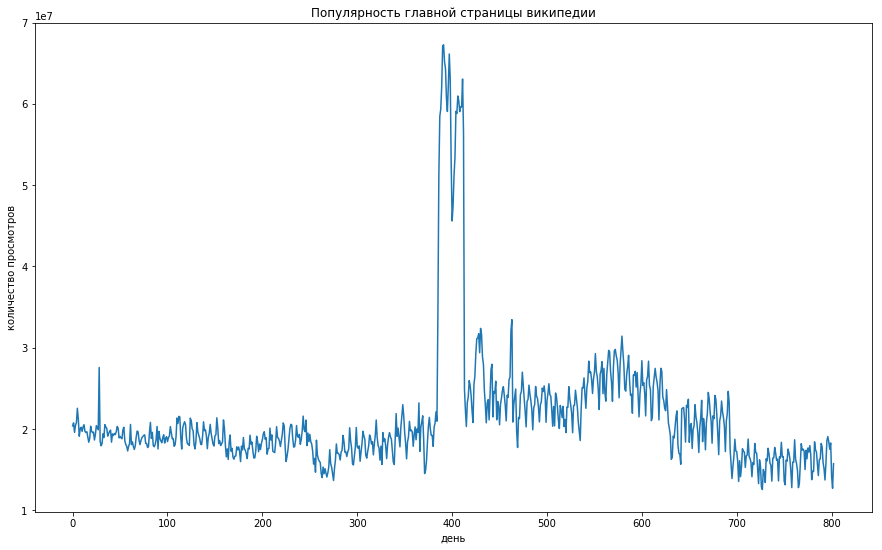

In [51]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)
ax.set_title('Популярность главной страницы википедии')
ax.set_xlabel('день')
ax.set_ylabel('количество просмотров')
ax.plot(np.arange(803), main.values.reshape(-1, 1))

Посмотрим на тренд

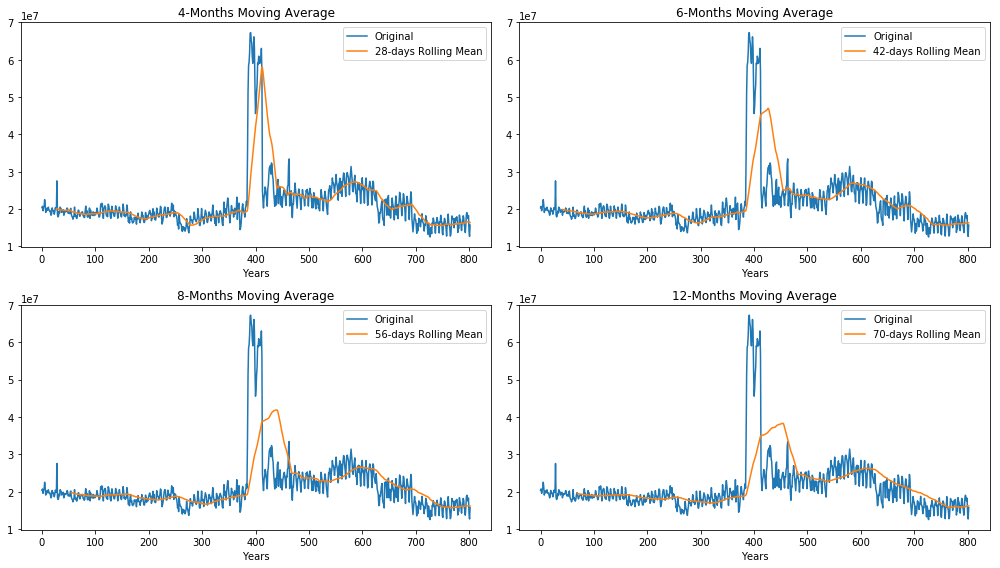

In [52]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(np.arange(803), main.values.reshape(-1, 1), label='Original')
axes[0][0].plot(np.arange(803), main.unstack().rolling(window=28).mean(), label='28-days Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(np.arange(803), main.values.reshape(-1, 1), label='Original')
axes[0][1].plot(np.arange(803), main.unstack().rolling(window=42).mean(), label='42-days Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(np.arange(803), main.values.reshape(-1, 1), label='Original')
axes[1][0].plot(np.arange(803), main.unstack().rolling(window=56).mean(), label='56-days Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(np.arange(803), main.values.reshape(-1, 1), label='Original')
axes[1][1].plot(np.arange(803), main.unstack().rolling(window=70).mean(), label='70-days Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

In [53]:
main.columns = pd.to_datetime(main.columns)

In [54]:
main = main.unstack().reset_index().drop('level_1', axis=1)

In [55]:
main.rename_axis({'level_0': 'date', 0: 'views'}, axis=1, inplace=True)

In [56]:
main.index = main.date

In [57]:
main.head()

,date,views
date,,
2015-07-01,2015-07-01,20381245
2015-07-02,2015-07-02,20752194
2015-07-03,2015-07-03,19573967
2015-07-04,2015-07-04,20439645
2015-07-05,2015-07-05,20772109


In [58]:
main.drop('date', inplace=True, axis=1)

In [59]:
main['month'] = main.index.month + (main.index.year - 2015) * 12
main['day'] = main.index.day

In [60]:
main.head()

,views,month,day
date,,,
2015-07-01,20381245,7,1
2015-07-02,20752194,7,2
2015-07-03,19573967,7,3
2015-07-04,20439645,7,4
2015-07-05,20772109,7,5


In [61]:
views_pivot = pd.pivot_table(main, values='views', columns='month', index='day')

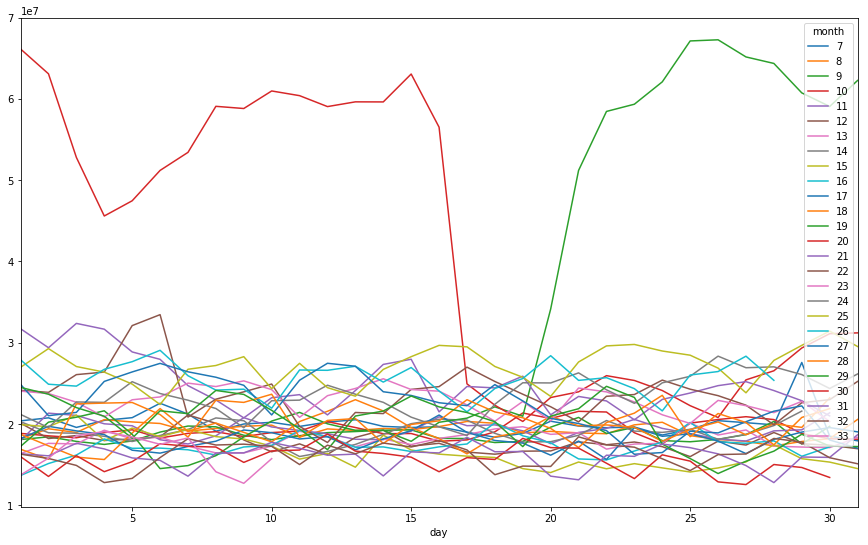

In [62]:
views_pivot.plot(figsize=(15, 9))

In [63]:
main['week'] = np.arange(main.shape[0]) // 7
main['week_day'] = np.arange(main.shape[0]) % 7

In [64]:
main.head(15)

,views,month,day,week,week_day
date,,,,,
2015-07-01,20381245,7,1,0,0
2015-07-02,20752194,7,2,0,1
2015-07-03,19573967,7,3,0,2
2015-07-04,20439645,7,4,0,3
2015-07-05,20772109,7,5,0,4
2015-07-06,22544669,7,6,0,5
2015-07-07,21210887,7,7,0,6
2015-07-08,19107911,7,8,1,0
2015-07-09,19993848,7,9,1,1


In [65]:
views_week_plot = pd.pivot_table(main, values='views', index='week_day', columns='week')

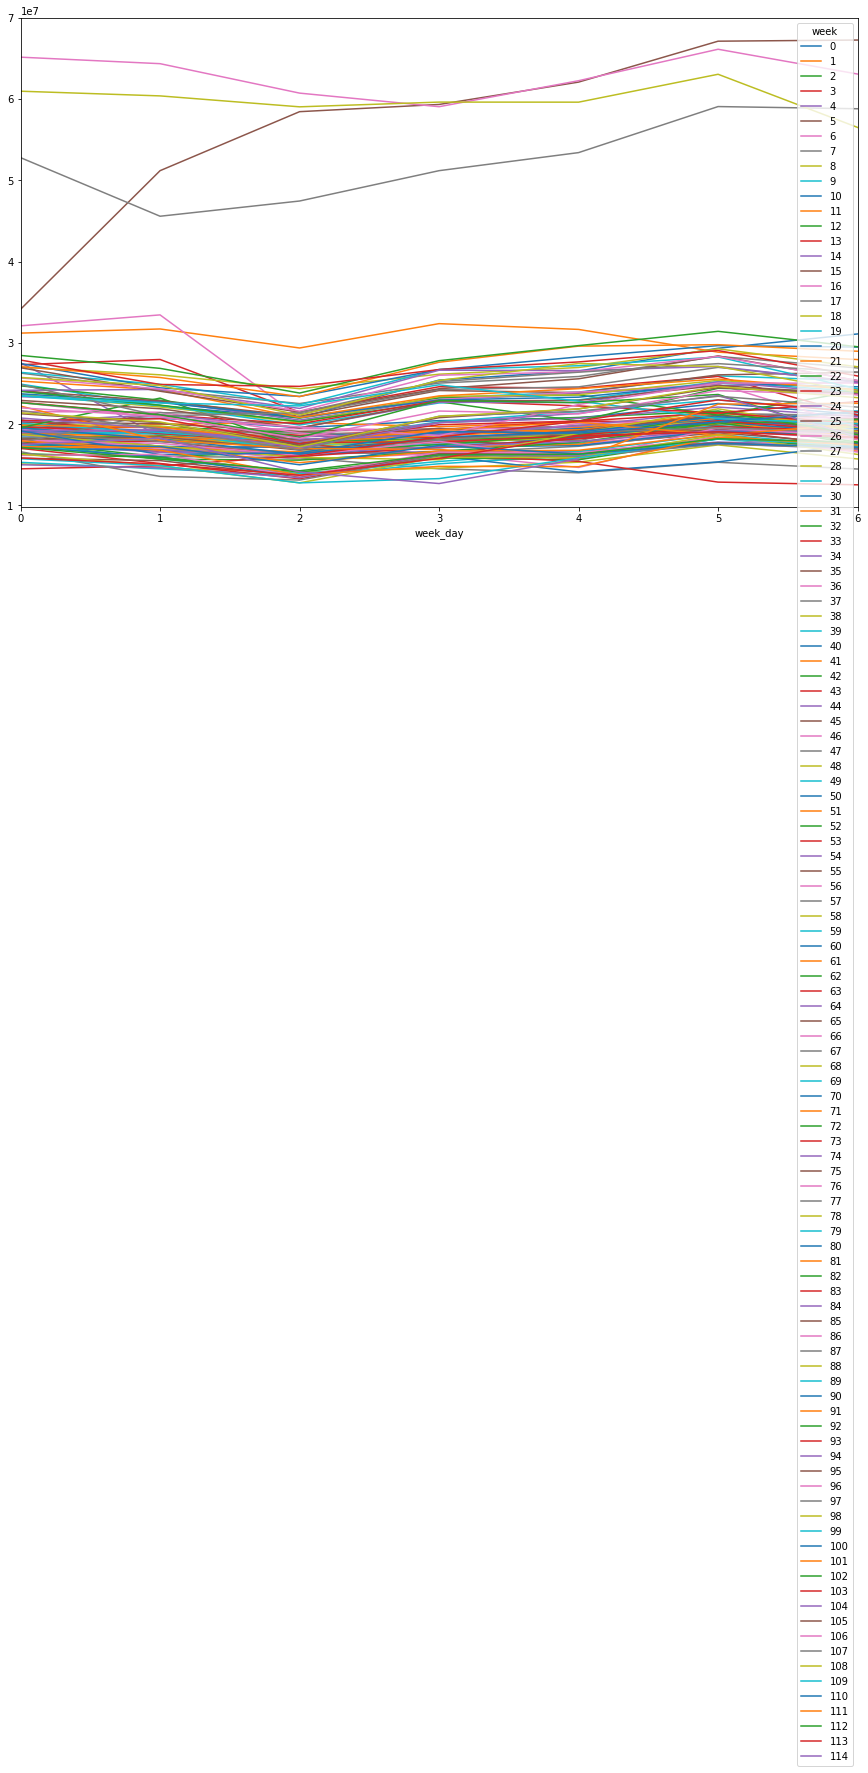

In [67]:
views_week_plot.plot(figsize=(15, 9))

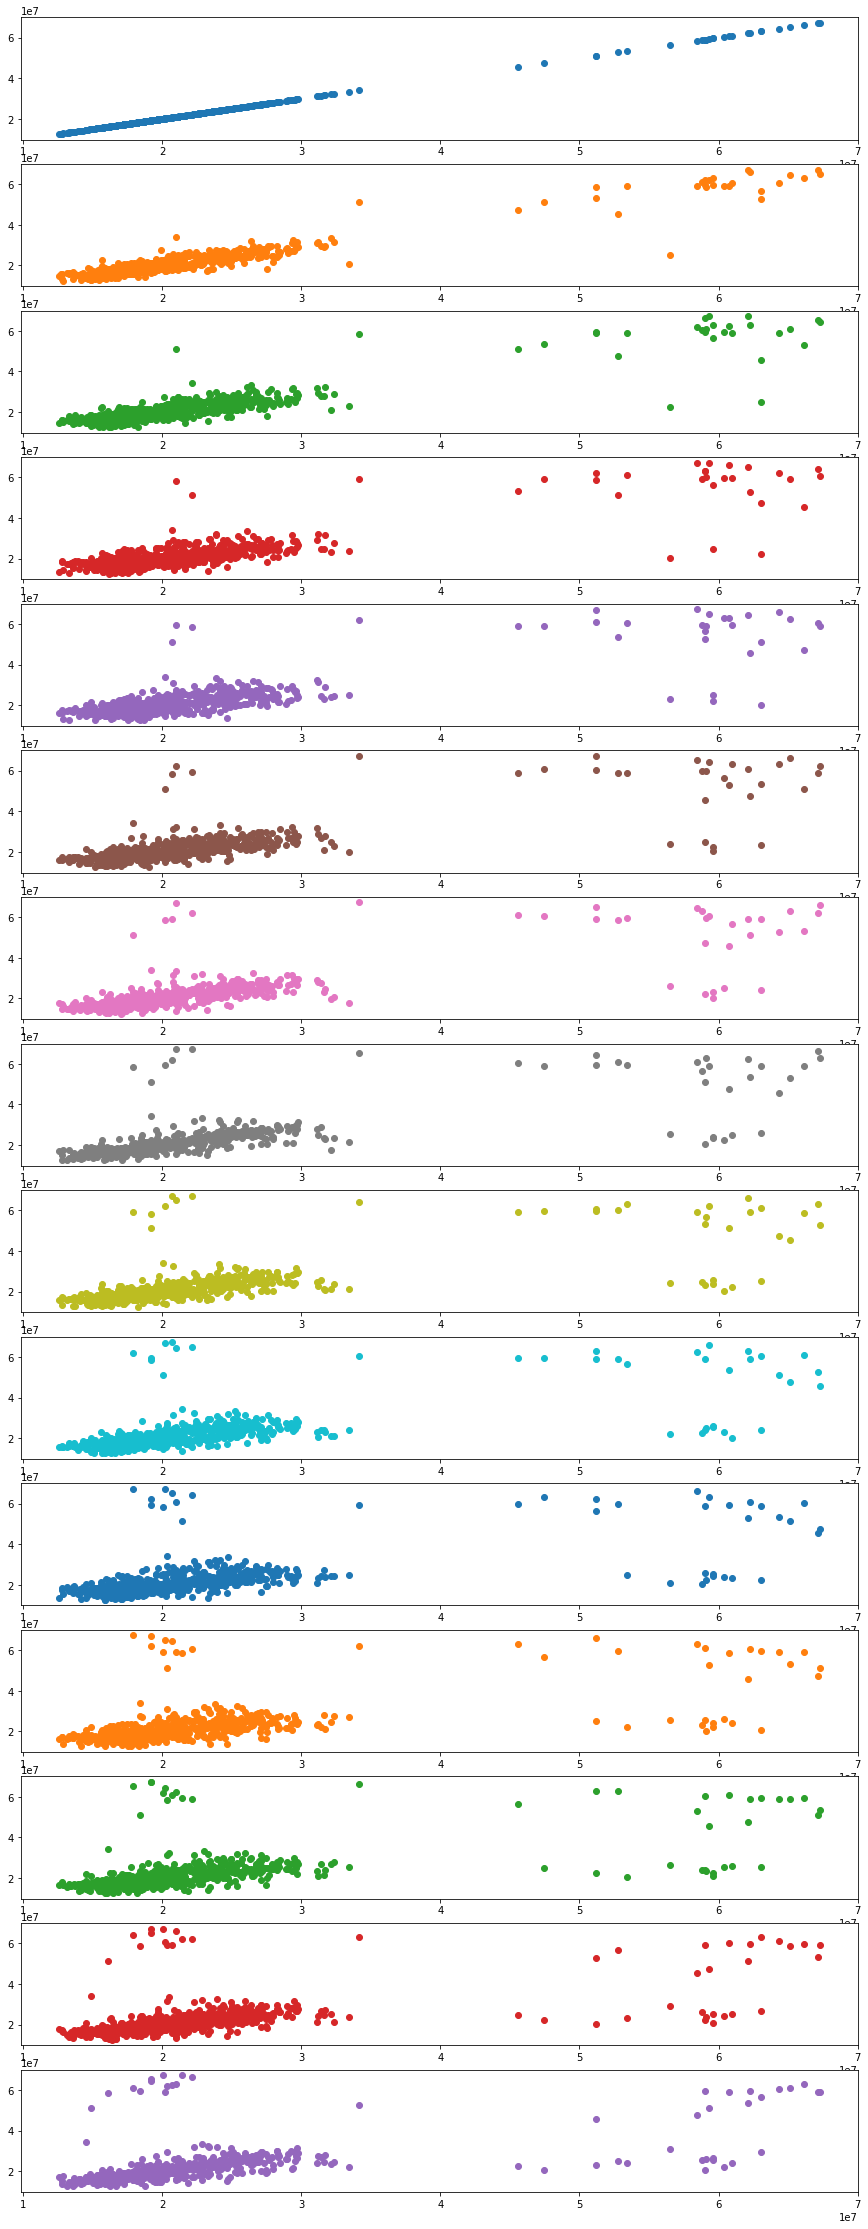

In [68]:
fig, axes = plt.subplots(15,1,figsize = (15,40))
for k, ax in enumerate(axes):
    for i in range(k):
        next(ax._get_lines.prop_cycler)
    ax.plot(main.views, main.views.shift(-k),'o')


plt.show()

Отчётливо прослеживается сезонность в одну неделю,а также выбросы в некоторых неделях

In [69]:
s = 7

In [70]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pylab import rcParams

/home/abi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


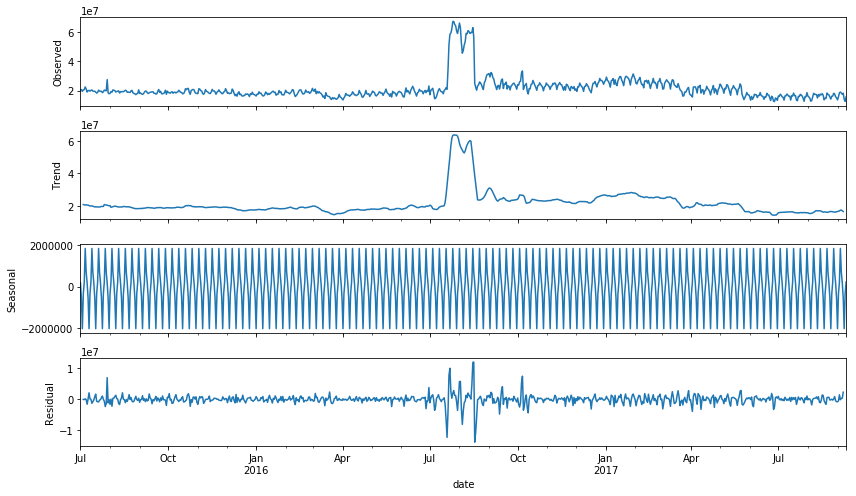

In [71]:
rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(main.views).plot()
plt.show()

Критерий Дики-Фуллера: p=0.000202


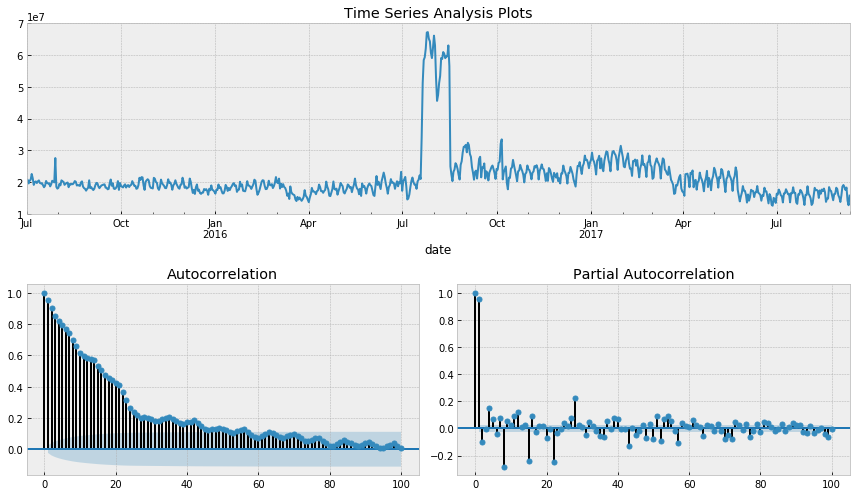

In [72]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(main.views, lags=100)

несмотря на то,что тест на стационарность проходится,видна сильная значимость первого лага.Возьмем первые разности

Критерий Дики-Фуллера: p=0.000000


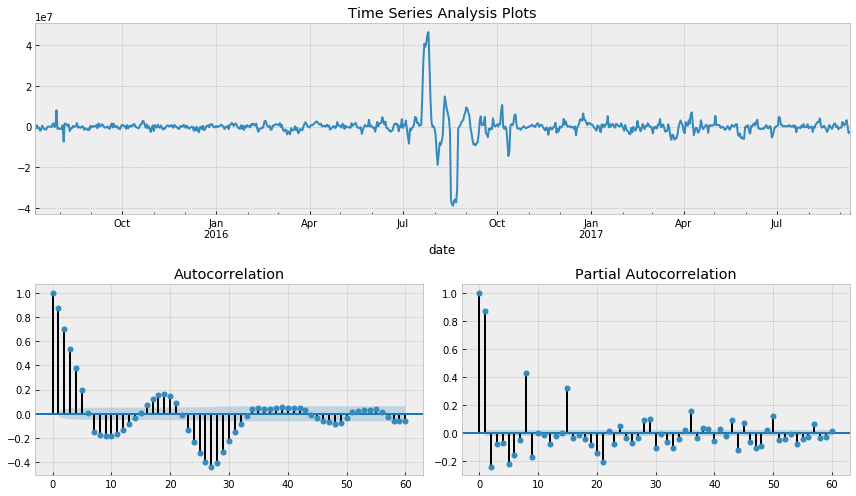

In [73]:
main['views_diffs_season'] = main.views - main.views.shift(7)
tsplot(main.views_diffs_season[7:], lags=60)

Критерий Дики-Фуллера: p=0.000000


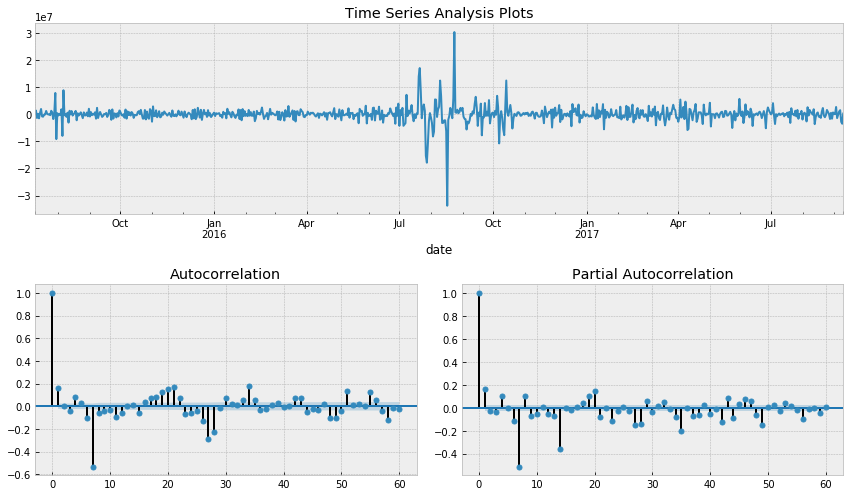

In [74]:
main['views_diffs_season_diffs'] = main.views_diffs_season - main.views_diffs_season.shift(1)
tsplot(main.views_diffs_season_diffs[8:], lags=60)

По автокорреляции мы видим значимость лага в 7 дней.Возьмем этот параметр в качестве размера сезона.
D=0(сезонного дифференцирования не было), d=1(одно несезонное дифференцирование)

In [75]:
s = 7
D = 1
d = 1
Ps = range(2)
Qs = range(2)
ps = range(4)
qs = range(4)

In [76]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

Сначала проведем валидацию и убедимся,что модель имеет право на жизнь:

In [77]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(main.views[:-30], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 3, 0, 0)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 3, 1, 0)
wrong parameters: (1, 3, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 0, 1)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 3, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 0, 1)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 3, 1, 1)
CPU times: user 35 s, sys: 188 ms, total: 35.2 s
Wall time: 28 s


In [78]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             views   No. Observations:                  773
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 7)   Log Likelihood              -12237.971
Date:                           Sun, 28 Apr 2019   AIC                          24481.943
Time:                                   23:38:10   BIC                          24495.894
Sample:                               07-01-2015   HQIC                         24487.311
                                    - 08-11-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.0015      0.037      0.041      0.967      -0.071       0.074
ma.S.L7       -0.9348      0.015    -63.951

Критерий Дики-Фуллера: p=0.000000


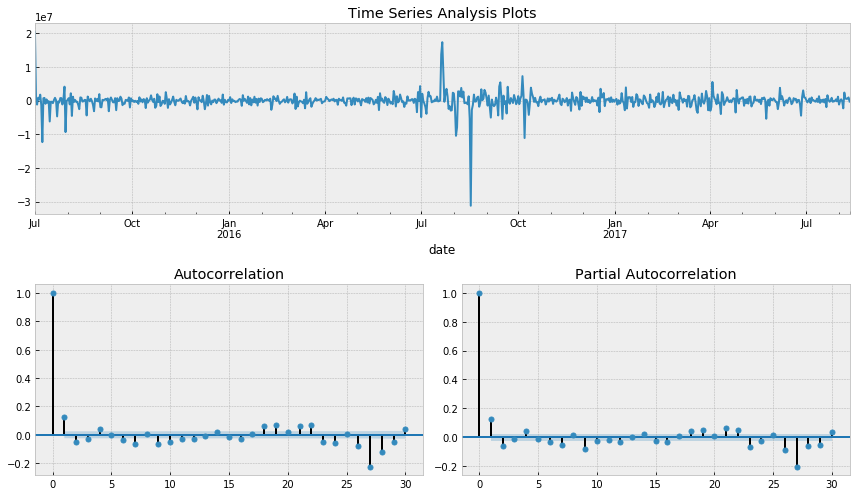

In [79]:
tsplot(best_model.resid, lags=30)

In [80]:
forecast = best_model.predict(main.views.shape[0] - 30, main.views.shape[0])

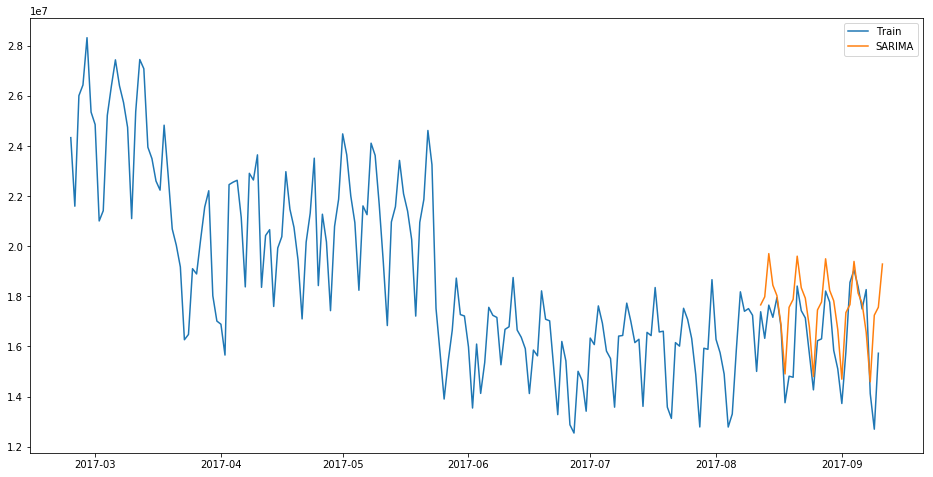

In [81]:
plt.figure(figsize=(16,8))
plt.plot(main.views[-200:], label='Train')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

Выглядит,навреное,не так уж и ужасно.Обучим модель на всех данных и построим прогноз на месяц вперед:

In [92]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(main.views, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 3, 0, 0)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 3, 1, 0)
wrong parameters: (1, 3, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 0, 1)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 3, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 0, 1)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 3, 1, 1)
CPU times: user 32.8 s, sys: 225 ms, total: 33 s
Wall time: 24.4 s


In [93]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             views   No. Observations:                  803
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 7)   Log Likelihood              -12708.644
Date:                           Sun, 28 Apr 2019   AIC                          25423.288
Time:                                   23:42:29   BIC                          25437.353
Sample:                               07-01-2015   HQIC                         25428.690
                                    - 09-10-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.0040      0.036      0.113      0.910      -0.066       0.074
ma.S.L7       -0.9351      0.014    -65.873

Критерий Дики-Фуллера: p=0.000000


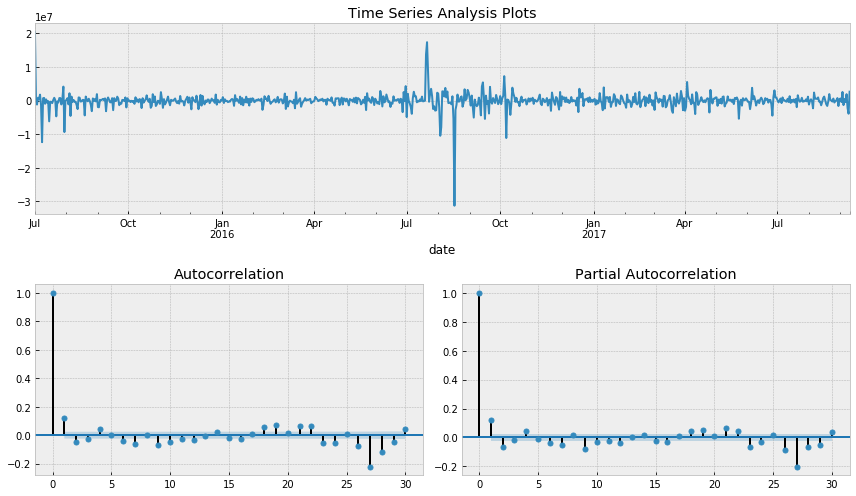

In [94]:
tsplot(best_model.resid, lags=30)

остатки стационарны, явных корреляций нет

In [111]:
forecast = best_model.predict(main.views.shape[0] - 1, main.views.shape[0] + 30)

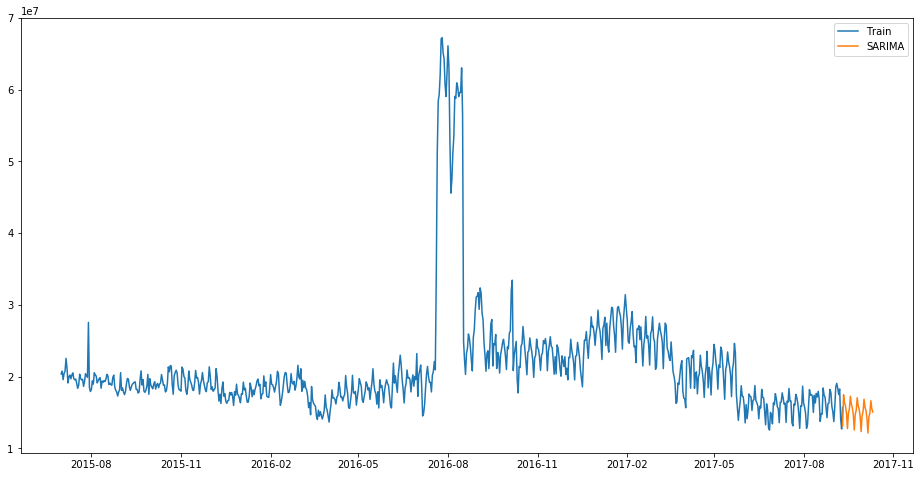

In [112]:
plt.figure(figsize=(16,8))
plt.plot(main.views, label='Train')
plt.plot(forecast, label='SARIMA')
plt.legend(loc='best')
plt.show()

Собственно,выводы по проверке гипотез были выше.Сделанный прогноз свидетельствует о том,что посещаемость главной страницы останется на предыдущем уровне, будет убывать и колебаться вокруг некоторого значения.Честно,я долго копался,где можно выцепить какое-нибудь распределение,чтобы применить параметрический критерий,но так ничего и не нашел.Я брал разрез по одной дате и пытался смотреть распределение.Оно походило на экспоненциальное,но критерии всё отвергали.